In [4]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

import matplotlib.pyplot as plt
print(np.__version__)

1.16.1


In [5]:
imdb = keras.datasets.imdb

# The argument num_words=10000 keeps the top 10,000 most frequently occurring words 
#in the training data. The rare words are discarded to keep the size of the data manageable.
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


In [18]:
print(train_data.shape)
print(len(train_data[0]))
print(train_data[0])

(25000,)
218
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


### Preprocessing

In [19]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


1646592/1641221 [==============================] - 0s 0us/step


In [20]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [0]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [26]:
print(train_data.shape)
print(train_labels.shape)


print(test_data.shape)
print(test_labels.shape)

(25000, 256)
(25000,)
(25000, 256)
(25000,)


In [27]:
train_data[0]

array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468,   66, 3941,    4,  173,   36,  256,    5,   25,  100,   43,
        838,  112,   50,  670,    2,    9,   35,  480,  284,    5,  150,
          4,  172,  112,  167,    2,  336,  385,   39,    4,  172, 4536,
       1111,   17,  546,   38,   13,  447,    4,  192,   50,   16,    6,
        147, 2025,   19,   14,   22,    4, 1920, 4613,  469,    4,   22,
         71,   87,   12,   16,   43,  530,   38,   76,   15,   13, 1247,
          4,   22,   17,  515,   17,   12,   16,  626,   18,    2,    5,
         62,  386,   12,    8,  316,    8,  106,    5,    4, 2223, 5244,
         16,  480,   66, 3785,   33,    4,  130,   12,   16,   38,  619,
          5,   25,  124,   51,   36,  135,   48,   25, 1415,   33,    6,
         22,   12,  215,   28,   77,   52,    5,   14,  407,   16,   82,
          2,    8,    4,  107,  117, 5952,   15,  256,    4,    2,    7,
       3766,    5,  723,   36,   71,   43,  530,  4

### Model

In [28]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


### The layers are stacked sequentially to build the classifier:

* The first layer is an Embedding layer. This layer takes the integer-encoded vocabulary 
and looks up the embedding vector for each word-index. These vectors are learned as the
model trains. The vectors add a dimension to the output array. The resulting dimensions
are: (batch, sequence, embedding).

* Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each 
example by averaging over the sequence dimension. This allows the model can handle input 
of variable length, in the simplest way possible.

* This fixed-length output vector is piped through a fully-connected (Dense) layer with 16
 hidden units.

* The last layer is densely connected with a single output node. Using the sigmoid 
activation function, this value is a float between 0 and 1, representing a probability,
or confidence level


### Loss function and optimizer
* A model needs a loss function and an optimizer for training. Since this is a binary 
classification problem and the model outputs of a probability (a single-unit layer with
 a sigmoid activation), we'll use the binary_crossentropy loss function.

* This isn't the only choice for a loss function, you could, for instance, choose
mean_squared_error. But, generally, binary_crossentropy is better for dealing with
probabilities—it measures the "distance" between probability distributions, or in our 
case, between the ground-truth distribution and the predictions.

* Later, when we are exploring regression problems (say, to predict the price of a house), 
we will see how to use another loss function called mean squared error.


In [0]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [0]:
# Create a validation set
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [31]:

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
15000/15000 [==============================] - 1s 98us/sample - loss: 0.6913 - acc: 0.5856 - val_loss: 0.6888 - val_acc: 0.6419
Epoch 2/40
15000/15000 [==============================] - 1s 68us/sample - loss: 0.6844 - acc: 0.7139 - val_loss: 0.6802 - val_acc: 0.7238
Epoch 3/40
15000/15000 [==============================] - 1s 64us/sample - loss: 0.6713 - acc: 0.7521 - val_loss: 0.6643 - val_acc: 0.7599
Epoch 4/40
15000/15000 [==============================] - 1s 64us/sample - loss: 0.6494 - acc: 0.7672 - val_loss: 0.6395 - val_acc: 0.7667
Epoch 5/40
15000/15000 [==============================] - 1s 64us/sample - loss: 0.6176 - acc: 0.7964 - val_loss: 0.6064 - val_acc: 0.7892
Epoch 6/40
15000/15000 [==============================] - 1s 64us/sample - loss: 0.5774 - acc: 0.8175 - val_loss: 0.5675 - val_acc: 0.8068
Epoch 7/40
15000/15000 [==============================] - 1s 64us/sa

In [32]:
results = model.evaluate(test_data, test_labels)

print(results)

25000/25000 [==============================] - 1s 38us/sample - loss: 0.3256 - acc: 0.8725
[0.32555994253635406, 0.87248]


In [33]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

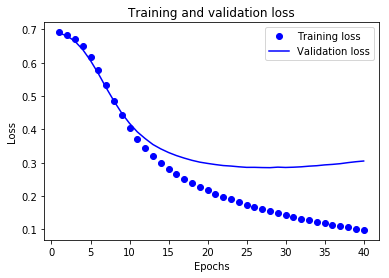

In [34]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

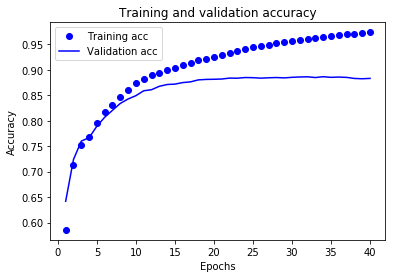

In [35]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Notice the training loss decreases with each epoch and the training accuracy increases
with each epoch. This is expected when using a gradient descent optimization—it should 
minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak after about 
twenty epochs. This is an example of overfitting: the model performs better on the 
training data than it does on data it has never seen before. After this point, the model 
over-optimizes and learns representations specific to the training data that do not 
generalize to test data.

For this particular case, we could prevent overfitting by simply stopping the training 
after twenty or so epochs. Later, you'll see how to do this automatically with a callback.